## Graph Neural Networks for predicting Solubility of ESOL Dataset Molecules.

### Step 1. Dataset: ESOL

> ESOL (Delaney dataset): ~1,128 compounds with experimental aqueous solubility values.

> Each molecule is given as a SMILES string (text form) that we’ll convert into a graph.

> Labels: solubility values (LogS).

### Step 2. Graph Construction

For each molecule:

> Nodes: atoms (features = atomic number, valence, aromaticity, etc.).

> Edges: bonds (features = bond type: single, double, aromatic).

> We’ll use RDKit to process SMILES into graphs and PyTorch Geometric (PyG) to store them as Data objects.

### Step 3. Model: GCN Baseline

> We’ll build a Graph Convolutional Network (GCN):

> Input layer → takes atom features.

> GCN layers → perform message passing between atoms.

> Global pooling → aggregates all atom embeddings into a molecule embedding.

> Fully connected layer → predicts solubility value.

### Step 4. Training Pipeline

> Loss: MSE (Mean Squared Error), since this is regression.

> Optimizer: Adam.

> Evaluation: RMSE (Root Mean Squared Error).

In [152]:
# Importing Libraries and Datasets
import torch
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import MoleculeNet
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import math

In [153]:
dataset = MoleculeNet(root="data/ESOL", name="ESOL")

In [154]:
dataset

ESOL(1128)

In [155]:
# Shuffle and Split Dataset into training and test sets:-

torch.manual_seed(42)
dataset = dataset.shuffle()

train_dataset = dataset[:900]
test_dataset = dataset[900:]

In [156]:
# DataLoader: -

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/Users/varunarora/opt/anaconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [157]:
# Defining 2-layer GCN Model : -

class GCN_2(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GCN_2, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, 1)
        
    def forward(self, x, edge_index, batch):
        # Node Embeddings with GCN Layers -
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # Global Pooling -
        
        x = global_mean_pool(x, batch)  # aggregate atoms → molecule
        
        # Prediction - 
        
        x = self.lin(x)  # predict solubility
        return x


In [158]:
# Train Function:-

def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data.x.float(), data.edge_index, data.batch)
        loss = criterion(out.squeeze(), data.y.float().squeeze())  
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

In [159]:
# Test Function:-

def test(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for data in loader:
            out = model(data.x.float(), data.edge_index, data.batch)
            preds.extend(out.squeeze().tolist())  
            labels.extend(data.y.float().squeeze().tolist())
    rmse = math.sqrt(mean_squared_error(labels, preds))
    return rmse

In [160]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training the 2-layer GCN Model:-

model = GCN_2(dataset.num_node_features, hidden_channels=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

In [161]:
# To run our model over 200 epochs, minimizing our MSE Loss and RSME

for epoch in range(1, 201):
    loss = train(model, train_loader, optimizer, criterion)
    rmse = test(model, test_loader)
    print(f"Epoch {epoch:03d}, Train Loss: {loss:.4f}, Test RMSE: {rmse:.4f}")

Epoch 001, Train Loss: 4.7516, Test RMSE: 2.0850
Epoch 002, Train Loss: 4.1968, Test RMSE: 2.0253
Epoch 003, Train Loss: 4.0060, Test RMSE: 2.0366
Epoch 004, Train Loss: 4.2983, Test RMSE: 2.0704
Epoch 005, Train Loss: 3.8326, Test RMSE: 1.9772
Epoch 006, Train Loss: 3.7051, Test RMSE: 2.0667
Epoch 007, Train Loss: 4.0437, Test RMSE: 1.9498
Epoch 008, Train Loss: 3.6693, Test RMSE: 1.9295
Epoch 009, Train Loss: 3.4821, Test RMSE: 1.9125
Epoch 010, Train Loss: 3.4606, Test RMSE: 1.8615
Epoch 011, Train Loss: 3.2745, Test RMSE: 1.8469
Epoch 012, Train Loss: 3.3280, Test RMSE: 1.8133
Epoch 013, Train Loss: 3.4521, Test RMSE: 1.8681
Epoch 014, Train Loss: 3.1594, Test RMSE: 1.9633
Epoch 015, Train Loss: 3.0927, Test RMSE: 1.7510
Epoch 016, Train Loss: 2.9786, Test RMSE: 1.7399
Epoch 017, Train Loss: 2.8237, Test RMSE: 1.7936
Epoch 018, Train Loss: 2.8793, Test RMSE: 1.6917
Epoch 019, Train Loss: 2.7056, Test RMSE: 1.7030
Epoch 020, Train Loss: 2.7043, Test RMSE: 1.7009
Epoch 021, Train Los

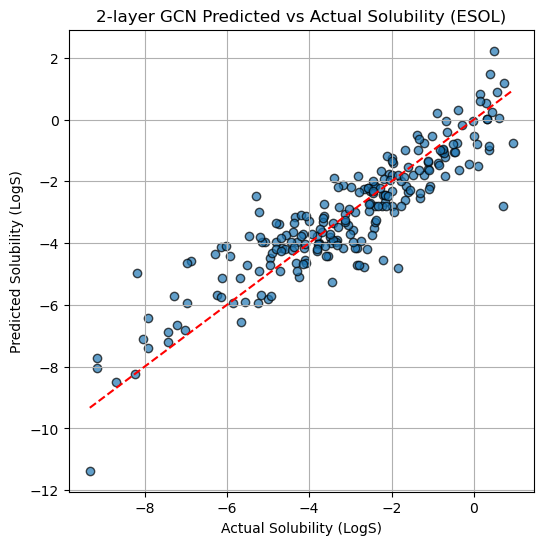

In [173]:
# ---- 7. Visualization: Predicted vs Actual Solubility ----

import matplotlib.pyplot as plt

def get_predictions(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for data in loader:
            out = model(data.x.float(), data.edge_index, data.batch)
            preds.extend(out.view(-1).tolist())
            labels.extend(data.y.float().tolist())
    return preds, labels

# Get predictions on test set (2-layer GCN): -

preds, labels = get_predictions(model, test_loader)

# Plot

plt.figure(figsize=(6,6))
plt.scatter(labels, preds, alpha=0.7, edgecolors="k")
plt.plot([min(labels), max(labels)], [min(labels), max(labels)], 'r--')  # y=x line
plt.xlabel("Actual Solubility (LogS)")
plt.ylabel("Predicted Solubility (LogS)")
plt.title("2-layer GCN Predicted vs Actual Solubility (ESOL)")
plt.grid(True)
plt.show()

In [162]:
# Predicting Solubility from Our 2-Layer GCN Model: -
from rdkit import Chem
from torch_geometric.utils import from_smiles

def predict_solubility(smiles, model, device="cpu"):
    model.eval()
    # Convert SMILES → Graph
    data = from_smiles(smiles)
    data.x = data.x.float()   # ensure features are float
    data = data.to(device)

    # Batch vector (all atoms belong to one molecule)
    batch = torch.zeros(data.num_nodes, dtype=torch.long).to(device)

    # Forward pass
    with torch.no_grad():
        out = model(data.x, data.edge_index, batch)
    return out.item()


In [163]:
# Let try to predict 'Log S' for different molecules (2-layer GCN): - 

molecules = {
    "Ethanol": "CCO",
    "Benzene": "c1ccccc1",
    "Aspirin": "CC(=O)OC1=CC=CC=C1C(=O)O"
}

for name, smi in molecules.items():
    pred = predict_solubility(smi, model, device)
    print(f"{name:10s} ({smi}): Predicted LogS = {pred:.4f}")


Ethanol    (CCO): Predicted LogS = 1.1262
Benzene    (c1ccccc1): Predicted LogS = -1.8758
Aspirin    (CC(=O)OC1=CC=CC=C1C(=O)O): Predicted LogS = -2.6738


In [164]:
# Now, let's try a 3-layer GCN :-

import torch.nn as nn

class GCN_3(nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GCN_3, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)   # NEW: 3rd GCN layer
        self.lin = nn.Linear(hidden_channels, 1)  

        self.dropout = nn.Dropout(p=0.3)  # NEW: dropout layer

    def forward(self, x, edge_index, batch):
        # 1st GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        # 2nd GCN layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        # 3rd GCN layer
        x = self.conv3(x, edge_index)
        x = F.relu(x)

        # Global pooling (mean of atom embeddings → molecule embedding)
        x = global_mean_pool(x, batch)

        # Linear regression layer
        x = self.lin(x)
        return x

In [165]:
# Train Function:-

def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data.x.float(), data.edge_index, data.batch)
        loss = criterion(out.squeeze(), data.y.float().squeeze())  
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

In [166]:
# Test Function:-

def test(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for data in loader:
            out = model(data.x.float(), data.edge_index, data.batch)
            preds.extend(out.squeeze().tolist())  
            labels.extend(data.y.float().squeeze().tolist())
    rmse = math.sqrt(mean_squared_error(labels, preds))
    return rmse

In [167]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training our model on 3-layer GCN Model: -

model_new = GCN_3(dataset.num_node_features, hidden_channels=128).to(device)
optimizer_new = torch.optim.Adam(model_new.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()

In [168]:
# To run our 3-layer GCN model over 200 epochs, minimizing our MSE Loss and RSME

for epoch in range(1, 201):
    loss_new = train(model_new, train_loader, optimizer_new, criterion)
    rmse_new = test(model_new, test_loader)
    print(f"Epoch {epoch:03d}, Train Loss: {loss:.4f}, Test RMSE: {rmse:.4f}")

Epoch 001, Train Loss: 1.0231, Test RMSE: 0.9471
Epoch 002, Train Loss: 1.0231, Test RMSE: 0.9471
Epoch 003, Train Loss: 1.0231, Test RMSE: 0.9471
Epoch 004, Train Loss: 1.0231, Test RMSE: 0.9471
Epoch 005, Train Loss: 1.0231, Test RMSE: 0.9471
Epoch 006, Train Loss: 1.0231, Test RMSE: 0.9471
Epoch 007, Train Loss: 1.0231, Test RMSE: 0.9471
Epoch 008, Train Loss: 1.0231, Test RMSE: 0.9471
Epoch 009, Train Loss: 1.0231, Test RMSE: 0.9471
Epoch 010, Train Loss: 1.0231, Test RMSE: 0.9471
Epoch 011, Train Loss: 1.0231, Test RMSE: 0.9471
Epoch 012, Train Loss: 1.0231, Test RMSE: 0.9471
Epoch 013, Train Loss: 1.0231, Test RMSE: 0.9471
Epoch 014, Train Loss: 1.0231, Test RMSE: 0.9471
Epoch 015, Train Loss: 1.0231, Test RMSE: 0.9471
Epoch 016, Train Loss: 1.0231, Test RMSE: 0.9471
Epoch 017, Train Loss: 1.0231, Test RMSE: 0.9471
Epoch 018, Train Loss: 1.0231, Test RMSE: 0.9471
Epoch 019, Train Loss: 1.0231, Test RMSE: 0.9471
Epoch 020, Train Loss: 1.0231, Test RMSE: 0.9471
Epoch 021, Train Los

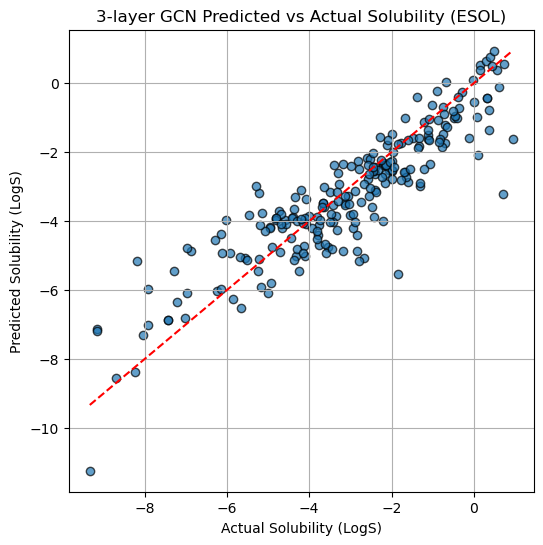

In [172]:
# Get predictions on test set (3-layer GCN): -

preds, labels = get_predictions(model_new, test_loader)

# Plots for 3-layer GCN :-

plt.figure(figsize=(6,6))
plt.scatter(labels, preds, alpha=0.7, edgecolors="k")
plt.plot([min(labels), max(labels)], [min(labels), max(labels)], 'r--')  # y=x line
plt.xlabel("Actual Solubility (LogS)")
plt.ylabel("Predicted Solubility (LogS)")
plt.title("3-layer GCN Predicted vs Actual Solubility (ESOL)")
plt.grid(True)
plt.show()

In [170]:
# Let try to predict 'Log S' for different molecules (3-Layer GCN) : - 

molecules = {
    "Ethanol": "CCO",
    "Benzene": "c1ccccc1",
    "Aspirin": "CC(=O)OC1=CC=CC=C1C(=O)O"
}

for name, smi in molecules.items():
    pred = predict_solubility(smi, model_new, device)
    print(f"{name:10s} ({smi}): Predicted LogS = {pred:.4f}")


Ethanol    (CCO): Predicted LogS = -0.1554
Benzene    (c1ccccc1): Predicted LogS = -2.3990
Aspirin    (CC(=O)OC1=CC=CC=C1C(=O)O): Predicted LogS = -2.5101


## Interpretation

1. Ethanol collapsed → the 3-layer network failed to recognize OH-driven solubility; dropout may have over-regularized.

2. Benzene got worse → deeper GCN might have led to over-smoothing (too many layers can make node embeddings indistinguishable).

3. Aspirin improved slightly (–2.67 → –2.18), but still not close enough to –1.64.

### So your 2-layer GCN proves to work out better than 3-layer GCN Model.